In [1]:
# SETUP
# =====
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import time
import timeit #for performance check
from geospatial import *

In [2]:
####### Point Index #######
# A class to illustrate a simple, grid based spatial index and 
# some basic functionality
class PointIndex():
    # initialise the index
    def __init__(self, data, box, res):                        
        # Work out number of rows and colums
        self.res = res
        w = box.ur.x - box.ll.x
        h = box.ur.y - box.ll.y
        self.nCols = int(w/ self.res) + 1 # +1 is to make sure the grid covers all of our points
        self.nRows = int(h/ self.res) + 1       
        self.points = [] # We will store the data here
        
        # Bounding box should be redefined to be same as grid now; we will use it later
        ur = Point(box.ll.x + (self.nCols * self.res), box.ll.y + (self.nRows * self.res))
        ll = box.ll
        self.bBox = Bbox([ll, ur])
        self.maxIndex = (self.nCols * self.nRows) -1 # Store the maximum possible index value, to use as a check
        self.bigArray = [] # This array is used to carry out brute force calcuations; it should be removed
        # Fill an empty index
        i = 0
        while i <= self.maxIndex:
            self.points.append([0,[]]) # The data structure stores a list containing tuples with the number of points and a list of points
            i += 1
            
        self.addPoints(data)

    # Pretty print of the data structure - note how we make sure things are displayed in the right order    
    def __repr__(self):
        s = f'Resolution: {self.res}\n'
        s = s + f'nCols: {self.nCols}\n'
        s = s + f'nRows: {self.nRows}\n'
        count = 0
        for r in range(0, self.nRows):
            for c in range(0,self.nCols):                
                index = (r * self.nCols) + c
                s = s + f'{self.points[index][0]}\t'
                count = count + self.points[index][0]                
            s = s + '\n'
        s = s + f'Points: {count}'
        return s
    
    # Method to add an array of point data - can add more data later, IF it is in our bounding box 
    def addPoints(self, data):
        for p in data:
            self.addPoint(p)
            self.bigArray.append(p) # Single bucket with all points

    # Put an individual point in the correct bucket, and increment its count        
    def addPoint(self, p):
        i = self.pointIndex(p)        
        if self.points[i][0] == 0:
            self.points[i] = [1, [p]]
        else:
            count = self.points[i][0]
            ps = self.points[i][1]
            ps.append(p)
            count +=1
            self.points[i] = [count, ps]
        
    # Get back the index of a point using its coordinates
    def pointIndex(self, p):
        j = int((p.y - self.bBox.ll.y)/ self.res)
        i = int((p.x - self.bBox.ll.x)/ self.res)
        return (j * self.nCols) + i  

    # Check if a point is stored in the index
    def contains(self, p):
        i = self.pointIndex(p)
        ps = self.points[i][1]
        return p in self.points
    
    # Get back all the points in a region
    def regionQuery(self, region):        
        # We first return the query region that intersects with our bounding box
        query = self.bBox.intersectsRegion(region)

        # If the query is wholly outside our index we return an empty list
        if query is None:
            return [], 0
        
        # Define the bounds of our search for points
        xStop = query.ur.x + self.res
        yStop = query.ur.y + self.res
        ps = []

        x = query.ll.x
        while (x <= xStop):
            y = query.ll.y
            while (y <= yStop):
                i = self.pointIndex(Point(x,y))
                if (i < self.maxIndex and self.points[i][0] > 0): # If bucket lies in index, and it contains points then
                    ps = [*ps, *self.points[i][1]]                # merge the points from this bucket
                y = y + self.res
            x = x + self.res
        
        #Now iterate through the points in the buckets, and only keep those in our query region
        final = []
        for p in ps:
            if (region.containsPoint(p)):
                final.append(p)
                
        return final, len(final)
                
    def nearestPoint(self, p):
        index = self.pointIndex(p)
        ps = []
        if (index >= 0 and index <= self.maxIndex):
            ps = self.points[index][1] # Get the points in this cell
        # If there are no points in the cell we look for more
        # Increase the range we search by the cell resolution
        step = self.res
        while len(ps) == 0:
            ll = Point(p.x - step, p.y - step)
            ur = Point(p.x + step, p.y + step)
            box = Bbox([ll,ur])
            ps, count = self.regionQuery(box)
            #print(f'Loop \n{p} \n{box}  \n{ps}')
            step = step + self.res

        oldCount = len(ps)
        #print(f'ps {ps} {len(ps)}')
        # Query the region given by the current minimum distance, to see if other points are nearer
        mDist = self.__minDist(ps, p)            
        # Create the region defined by this distance
        ll = Point(p.x - mDist[1], p.y - mDist[1])
        ur = Point(p.x + mDist[1], p.y + mDist[1])            
        ps2, count = self.regionQuery(Bbox([ll, ur]))
        #print(f'ps2 {count} {len(ps)}')                            
        if (count > oldCount): # We only need to recalculate if there are new candidate points
            mDist = self.__minDist(ps2, p)                        
        return mDist
        
    def __minDist(self, points, p):
        dist = []
        for q in points:
            d = p.distEuclidean(q)
            dist.append([q, d]) # Store points and their distances
        mDist = min(dist, key=lambda dist: dist[1]) # Use lamda function to get get minimum distance 
        return mDist

    def bruteNearestPoint(self, p):
        return self.__minDist(self.bigArray, p)
    
    # Get back all the points in a region, iterating through all possible points
    def bruteRegionQuery(self, region):        
        # We first return the query region that intersects with our bounding box
        query = self.bBox.intersectsRegion(region)

        # If the query is wholly outside our index we return an empty list
        if query is None:
            return [], 0
        
        #Now iterate through the points in the big list, and only keep those in our query region
        final = []
        for p in self.bigArray:
            if (region.containsPoint(p)):
                final.append(p)
                
        return final, len(final)



In [10]:
# TEST DATA
# =========
# a random group of points
sample = []
n = 500000
xs = 0
xf = 100
ys = 0
yf = 100
res = 10
for i in range(n): # Create n random Points to test
    x = random.uniform(xs, xf)
    y = random.uniform(ys, yf)
    p = Point(x,y)
    sample.append(p)

box = Bbox([Point(xs, ys), Point(xf, yf)])

print(box)

pg = PointIndex(sample, box, res)

print(pg)

Bounding box with lower-left Point(x=0.00, y=0.00) and upper-right Point(x=100.00, y=100.00)
Resolution: 10
nCols: 11
nRows: 11
5105	4956	5059	4998	4955	5031	5022	5041	5008	5046	0	
4896	5049	5072	4792	4915	4945	5023	5051	5002	5057	0	
4972	5026	5013	5099	4907	4996	5042	4989	4981	5001	0	
4935	5118	4985	5013	4913	4921	4932	4958	5013	5171	0	
4917	5002	4941	4979	5051	4888	5012	5051	4949	4978	0	
5007	5036	5023	4976	4955	5041	5030	5009	5028	4963	0	
4957	5017	5050	5025	4927	4840	4980	5041	4937	5023	0	
4979	5093	4998	4944	4987	4941	5047	4965	5015	5045	0	
5008	5103	5045	5029	5030	4905	4949	5080	5016	4975	0	
5011	5060	5062	5034	5018	4993	5002	5015	5024	4986	0	
0	0	0	0	0	0	0	0	0	0	0	
Points: 500000


95.4 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.9 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Too many points, only showing query region


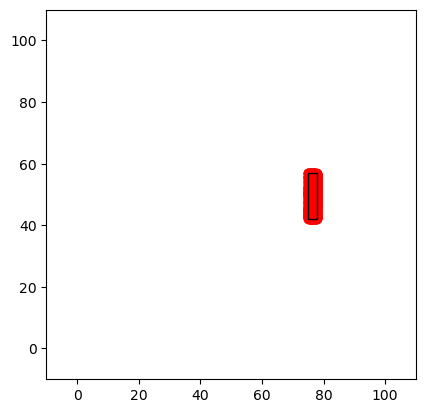

In [8]:
# Create a random query region
xl =  random.randint(xs-5, xf+5)
yl =  random.randint(ys-5, yf+5)
width =  random.randint(1, 20)
height =  random.randint(1, 20)

query = Bbox([Point(xl,yl), Point(xl + width, yl + height)])

%timeit pg.bruteRegionQuery(query)

%timeit pg.regionQuery(query)

results, count = pg.regionQuery(query)

# Plotting points, results and query region
figure, axes = plt.subplots()

# Plot query region
x = query.ll.x
y = query.ll.y
w = query.ur.x - query.ll.x
h = query.ur.y - query.ll.y
rect = plt.Rectangle((x,y), w, h, fill=False)


if n < 1000:
    #Plot all points
    xvs = [x.x for x in sample]
    yvs = [x.y for x in sample]
    c = 'green'
    plt.scatter(xvs, yvs, color=c)

else:
    print('Too many points, only showing query region')


#Plot points in query region
xvs = [x.x for x in results]
yvs = [x.y for x in results]
c = 'red'
plt.scatter(xvs, yvs, color=c)
    
plt.xlim([xs-10, xf+10])
plt.ylim([ys-10, yf+10])
axes.set_aspect(1)
axes.add_artist(rect)
plt.show()

In [11]:
# Random query point
xl =  random.uniform(xs-10, xf+10)
yl =  random.uniform(ys-10, yf+10)
q = Point(xl, yl)
r, dist = pg.nearestPoint(q)

%timeit pg.nearestPoint(q)
%timeit pg.bruteNearestPoint(q)

r, dist = pg.nearestPoint(q)
print (f'The nearest point (using the spatial index) to {q} is {r} with a distance of {dist:.2f} units.')

r, dist = pg.bruteNearestPoint(q)
print (f'The nearest point (using brute force) to {q} is {r} with a distance of {dist:.2f} units.')

19.8 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
569 ms ± 26.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
The nearest point (using the spatial index) to Point(x=78.56, y=39.46) is Point(x=78.58, y=39.33) with a distance of 0.13 units.
The nearest point (using brute force) to Point(x=78.56, y=39.46) is Point(x=78.58, y=39.33) with a distance of 0.13 units.


Too many points, only showing query point and result


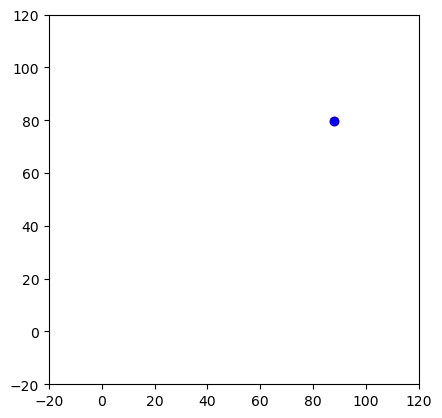

In [6]:
# Plot results
figure, axes = plt.subplots()
    
#Plot the query point
c = 'red'
plt.scatter(q.x, q.y, color=c)

#Plot the nearest point
c = 'blue'
plt.scatter(r.x, r.y, color=c)

#Plot a circle around the query point, radius is distance to solution
circle = plt.Circle((q.x, q.y), dist,fill=False)

axes.set_aspect(1)
axes.add_artist(circle)
plt.xlim([xs-20, xf+20])
plt.ylim([ys-20, yf+20])

if n < 1000:
    #Plot all points
    xvs = [x.x for x in sample]
    yvs = [x.y for x in sample]
    c = 'green'
    plt.scatter(xvs, yvs, color=c)
else:
    print('Too many points, only showing query point and result')

plt.show()